In [5]:
# Imports
import pandas as pd
import yfinance as yf
import numpy as np
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
import numba as nb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, roc_auc_score

import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from notebooks.mlfinlab.corefns.core_functions import CoreFunctions
from notebooks.mlfinlab.corefns.financial_functions import FinancialFunctions

In [10]:
# Functions

#Cargamos ambos files y los unimos, usando como indices en ambos las fechas.
def load_and_join():
    mtum = yf.Ticker("MTUM")
    stocks = ["MTUM"]
    start = datetime.datetime(2000,11,30)
    end = datetime.datetime(2019,11,30)
    
    yf.pdr_override()
    
    df_etf = pdr.get_data_yahoo(stocks, start=start, end=end)
    
    df = pd.read_excel('https://images.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Century-of-Factor-Premia-Monthly.xlsx',
                      header =18, nrows = 1220)
    
    df['Date'] =  pd.to_datetime(df['Date'])
    
    
    df = df.set_index('Date')
    df = df[['Equity indices Value','Equity indices Momentum','Equity indices Carry','Equity indices Defensive']]
    
    df_final = df_etf.merge(df, how='left',left_index=True,right_index=True)
    
    return df_final

#Extendemos los datos mensuales a los registros diarios. (Ejemplo: todos los datos de enero, tomaran el valor monthly del 31/01)
def fill_joined_missing_fields(df):
    for i in range(1,len(df)+1):
        if np.isnan(df.iloc[-i,9]):
                df.iloc[-i,6] = df.iloc[-i+1,6]
                df.iloc[-i,7] = df.iloc[-i+1,7]
                df.iloc[-i,8] = df.iloc[-i+1,8]
                df.iloc[-i,9] = df.iloc[-i+1,9]
         

#Introducimos labels al dataset, calculando medias 50 y 200 dias.
'''(REVEER!)'''    
def labeling_df(df):
    df['50_days_average'] = df.iloc[:,3].rolling(window=10).mean()
    df['200_days_average'] = df.iloc[:,3].rolling(window=30).mean()
    df.loc[df['50_days_average'] >= df['200_days_average'], 'Buy/Sell'] = -1 #Si la media de corto plazo supera a la de largo, es posicion de sell
    df.loc[df['50_days_average'] < df['200_days_average'], 'Buy/Sell'] = 1 #Si la media de corto plazo esta por debajo de la de largo, es posicion de buy
    return df
 
#Visualizacion de la evolucion de precios y las medias.
def visualize_close_50_200(df):
    plt.plot(df['Close'])
    plt.plot(df['50_days_average'])
    plt.plot(df['200_days_average'])
    plt.legend(['Close','50_days_avg','200_days_avg'])
    plt.title('Evolution of MTUM ETF over time')
    plt.show()

#Consigue los weights para la diferenciacion!
def getWeights_FFD(d,size):
    w=[1.]
    for k in range(1,size):
        w_=-w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w

#Funcion aux para pesos de FFD
def plotWeights(dRange,nPlots,size):
    w=pd.DataFrame()
    for d in np.linspace(dRange[0],dRange[1],nPlots):
        w_=getWeights_FFD(d,size=size)
        w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
        w=w.join(w_,how='outer')
    ax=w.plot()
    ax.legend(loc='upper right');plt.show()
    return

#Diferenciamos la serie! d es el orden de diferenciacion. "Thres" (threshold) maneja la acceptabilidad de las exclusiones. No modificar.
#to do
def fracDiff(series,d,thres=0.01):

    w=getWeights_FFD(d,series.shape[0])

    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip=w_[w_>thres].shape[0]

    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]

            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

#Funcion para buscar el mejor d
def plotMinFFD(df):
    from statsmodels.tsa.stattools import adfuller
    import numpy.ma as ma
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    for d in np.linspace(0,1,21):
        df1=np.log(df[['Close']]).resample('1D').last() # Pasar a observaciones diarias
        df2=fracDiff(df1,d,thres=.01)
        corr = ma.corrcoef(ma.masked_invalid(df1.loc[df2.index,'Close']), ma.masked_invalid(df2['Close']))[0,1]
        df2=adfuller(df2['Close'],maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # Aportar valores criticos
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    plt.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    plt.show()
    return out

#TODO: mejorar graficas, mattplotlib sos muy feo
def plotROC(rf):
    y_pred_rf = rf.predict_proba(X_test)[:, 1]
    y_pred = rf.predict(X_test)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
    print(classification_report(y_test, y_pred))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    auc = roc_auc_score(y_true = y_test, y_score = y_pred)
    print(f"auc: {auc}")

#TODO: mejorar graficas, mattplotlib sos muy feo
def plotImportance(rf):
    # Feature Importance
    title = 'Feature Importance:'
    figsize = (15, 5)

    feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
    feat_imp['feature'] = X.columns
    feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
    feat_imp = feat_imp

    feat_imp.sort_values(by='Importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()

    
#Obtiene los factores de tiempo para restar importancia a las observaciones.
def getTimeDecay(tW,clfLastW):
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0:slope=(1.-clfLastW)/clfW.iloc[-1]
    else:slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    # print(const,slope)
    return clfW

def timeseries_train_test_split(X, y, test_size):
    """
        train test segun un esquema para series de tiempo
    """
    
    # tomamos el indice en donde empieza el test
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


# Compute RSI
def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = FinancialFunctions.relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [11]:
dataset = load_and_join()
fill_joined_missing_fields(dataset) 


[*********************100%***********************]  1 of 1 completed


<h3>Modelo base</h3>

/home/aldo/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


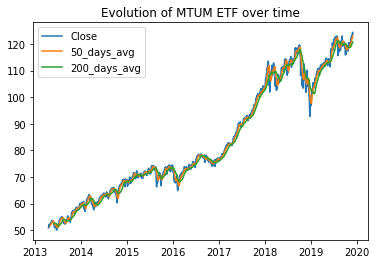

In [4]:
df = dataset.copy();

#Ploteando series
df = labeling_df(df);
plt.figure(2);
visualize_close_50_200(df);


In [10]:
df_aux = df.dropna()
X = df_aux.iloc[:,:12]
y = df_aux.iloc[:,12:]

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=10, n_estimators=n_estimator,
                            criterion='entropy', random_state=42)
rf.fit(X_train, y_train)


/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

              precision    recall  f1-score   support

        -1.0       0.68      1.00      0.81       334
         1.0       0.00      0.00      0.00       158

    accuracy                           0.68       492
   macro avg       0.34      0.50      0.40       492
weighted avg       0.46      0.68      0.55       492



/home/aldo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


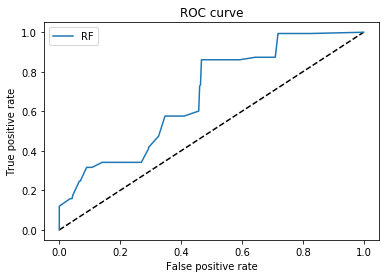

auc: 0.5


In [11]:
plotROC(rf)

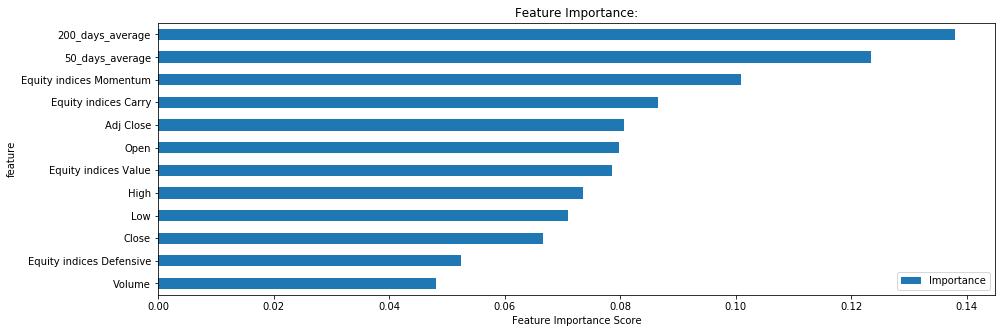

In [12]:
plotImportance(rf)

In [21]:
df_ffd

,Open,High,Low,Close,Adj Close,Volume,Equity indices Value,Equity indices Momentum,Equity indices Carry,Equity indices Defensive
Date,,,,,,,,,,
2013-04-18,50.919998,50.919998,50.919998,50.919998,46.707516,400,0.008630,-0.011301,0.006270,-0.027077
2013-04-19,50.919998,50.919998,50.919998,50.919998,46.707516,0,0.008630,-0.011301,0.006270,-0.027077
2013-04-22,50.919998,50.919998,50.919998,50.919998,46.707516,0,0.008630,-0.011301,0.006270,-0.027077
2013-04-23,52.220001,52.220001,52.220001,52.220001,47.899956,600,0.008630,-0.011301,0.006270,-0.027077
2013-04-24,51.700001,51.700001,51.560001,51.560001,47.294567,1100,0.008630,-0.011301,0.006270,-0.027077
...,...,...,...,...,...,...,...,...,...,...
2019-11-22,122.360001,122.360001,121.699997,122.169998,121.672653,561400,-0.029074,0.038236,-0.003343,0.024068
2019-11-25,122.669998,123.110001,122.309998,123.019997,122.519188,385000,-0.029074,0.038236,-0.003343,0.024068
2019-11-26,123.180000,124.059998,123.089996,123.980003,123.475288,611600,-0.029074,0.038236,-0.003343,0.024068


In [22]:
df_ffd

,Open,High,Low,Close,Adj Close,Volume,Equity indices Value,Equity indices Momentum,Equity indices Carry,Equity indices Defensive
2017-10-05,68.651106,68.790531,68.422843,68.849273,66.948833,160316.896413,-0.004625,0.009368,-0.006645,0.008321
2017-10-06,68.786840,68.822769,68.740003,68.886781,66.983523,189369.602180,-0.004842,0.009357,-0.006812,0.008049
2017-10-09,69.058726,68.988440,68.613063,68.719065,66.819288,259230.862245,-0.005001,0.009345,-0.006934,0.007840
2017-10-10,68.956039,68.933051,68.545520,68.867755,66.962160,115377.545955,-0.005124,0.009333,-0.007026,0.007673
2017-10-11,68.949667,68.888529,68.654471,68.959624,67.050010,403386.696391,-0.005220,0.009320,-0.007099,0.007534
...,...,...,...,...,...,...,...,...,...,...
2019-11-22,84.756009,84.618345,84.295856,84.595974,84.489976,276817.422403,-0.024301,0.033261,-0.001096,0.020469
2019-11-25,85.061048,85.374044,84.898813,85.433422,85.323262,106145.413990,-0.024223,0.033117,-0.001135,0.020383
2019-11-26,85.541503,86.279572,85.635199,86.336807,86.222234,345337.298745,-0.024149,0.032981,-0.001171,0.020302
2019-11-27,86.672978,86.613904,86.287290,86.704046,86.587252,845996.348303,-0.024081,0.032855,-0.001204,0.020226


<h3>Modelo 1: agregamos diferenciacion fraccionaria</h3>

<Figure size 432x288 with 0 Axes>

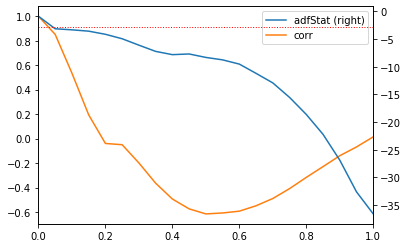

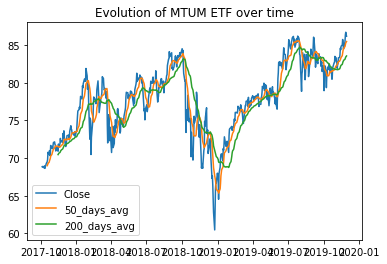

In [18]:

#Diferenciacion fraccionaria: Buscando el mejor d, d* = 0.1
plt.figure(1)
out = plotMinFFD(dataset)

#Usando la diferenciacion con d = 0.05
df_ffd = fracDiff(dataset,0.05)  

#Ploteando series
df_ffd = labeling_df(df_ffd)
plt.figure(3)
visualize_close_50_200(df_ffd)

#time_decay = getTimeDecay(dataset[['Close']],0)

/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


              precision    recall  f1-score   support

        -1.0       0.92      0.95      0.94        62
         1.0       0.97      0.95      0.96        92

    accuracy                           0.95       154
   macro avg       0.94      0.95      0.95       154
weighted avg       0.95      0.95      0.95       154



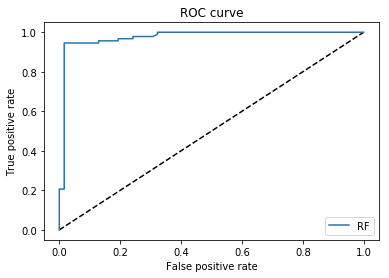

0.9486325385694251


In [8]:
df_aux = df_ffd.dropna()
X = df_aux.iloc[:,:12]
y = df_aux.iloc[:,12:]

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=10, n_estimators=n_estimator,
                            criterion='entropy', random_state=42)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
auc = roc_auc_score(y_true = y_test, y_score = y_pred)
print(auc)

vemos que overfitea, entonces a este modelo le vamos a agregar variables adicionales

In [14]:
df_ffd

,Open,High,Low,Close,Adj Close,Volume,Equity indices Value,Equity indices Momentum,Equity indices Carry,Equity indices Defensive,50_days_average,200_days_average,Buy/Sell
2017-10-05,68.651106,68.790531,68.422843,68.849273,66.948833,160316.896413,-0.004625,0.009368,-0.006645,0.008321,NaN,NaN,NaN
2017-10-06,68.786840,68.822769,68.740003,68.886781,66.983523,189369.602180,-0.004842,0.009357,-0.006812,0.008049,NaN,NaN,NaN
2017-10-09,69.058726,68.988440,68.613063,68.719065,66.819288,259230.862245,-0.005001,0.009345,-0.006934,0.007840,NaN,NaN,NaN
2017-10-10,68.956039,68.933051,68.545520,68.867755,66.962160,115377.545955,-0.005124,0.009333,-0.007026,0.007673,NaN,NaN,NaN
2017-10-11,68.949667,68.888529,68.654471,68.959624,67.050010,403386.696391,-0.005220,0.009320,-0.007099,0.007534,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-22,84.756009,84.618345,84.295856,84.595974,84.489976,276817.422403,-0.024301,0.033261,-0.001096,0.020469,84.596962,82.999870,-1.0
2019-11-25,85.061048,85.374044,84.898813,85.433422,85.323262,106145.413990,-0.024223,0.033117,-0.001135,0.020383,84.806714,83.120605,-1.0
2019-11-26,85.541503,86.279572,85.635199,86.336807,86.222234,345337.298745,-0.024149,0.032981,-0.001171,0.020302,85.072107,83.251015,-1.0
2019-11-27,86.672978,86.613904,86.287290,86.704046,86.587252,845996.348303,-0.024081,0.032855,-0.001204,0.020226,85.285487,83.417825,-1.0


<h3>Modelo 2: agregamos X variables</h3>

In [ ]:
#https://stackoverflow.com/questions/35180846/most-pythonic-way-to-create-many-new-columns-in-pandas

In [20]:
rsi_windows = [5, 13, 34, 55]
df_ffd.columns = map(str.lower, df_ffd.columns)
for w in rsi_windows:
    rsi = get_rsi(df_ffd, window=w).squeeze()
    df_ffd[f'rsi_{w}'] = rsi
    
df_ffd.dropna(inplace=True)

df_ffd['log_ret'] = np.log(df_ffd['close']).diff()

# momentum 
for w in rsi_windows:
    df_ffd[f'mom_{w}'] = df_ffd['close'].pct_change(w)
    
# vol
for w in rsi_windows:
    df_ffd[f'vol_{w}'] = (df_ffd['log_ret']
                            .rolling(window=w, min_periods=w, center=False)
                            .std())
    
# autocorr
window_autocorr = 50
df_ffd['autocorr_1'] = (df_ffd['log_ret']
                          .rolling(window=window_autocorr, 
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=1), raw=False))

df_ffd['autocorr_2'] = (df_ffd['log_ret']
                          .rolling(window=window_autocorr, 
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=3), raw=False))

df_ffd['autocorr_3'] = (df_ffd['log_ret']
                          .rolling(window=window_autocorr, 
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=5), raw=False))

In [16]:
df_ffd

,open,high,low,close,adj close,volume,equity indices value,equity indices momentum,equity indices carry,equity indices defensive,...,mom_13,mom_34,mom_55,vol_5,vol_13,vol_34,vol_55,autocorr_1,autocorr_2,autocorr_3
2017-12-21,73.904388,73.829058,73.404858,73.355550,71.584363,177698.031980,0.005036,-0.015234,0.024383,0.025600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-22,73.454460,73.386489,73.039832,73.326855,71.541184,132582.204111,0.004994,-0.015173,0.024276,0.025550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-26,73.102258,73.038527,72.886322,73.041008,71.255661,118794.250635,0.004956,-0.015117,0.024177,0.025502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-27,73.116509,73.305859,72.890547,73.306570,71.509158,825812.908416,0.004920,-0.015064,0.024084,0.025456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-28,73.568301,73.497586,73.477791,73.491164,71.685107,196158.815033,0.004887,-0.015014,0.023996,0.025413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-22,84.756009,84.618345,84.295856,84.595974,84.489976,276817.422403,-0.024301,0.033261,-0.001096,0.020469,...,0.032605,0.037589,-0.015212,0.006994,0.005838,0.009398,0.011373,-0.142312,-0.032978,-0.089626
2019-11-25,85.061048,85.374044,84.898813,85.433422,85.323262,106145.413990,-0.024223,0.033117,-0.001135,0.020383,...,0.036998,0.076658,0.019468,0.008450,0.006139,0.008083,0.010943,-0.126443,-0.041439,-0.085947
2019-11-26,85.541503,86.279572,85.635199,86.336807,86.222234,345337.298745,-0.024149,0.032981,-0.001171,0.020302,...,0.046347,0.069114,0.052016,0.008946,0.006481,0.007762,0.010628,-0.110964,-0.045174,-0.035689
2019-11-27,86.672978,86.613904,86.287290,86.704046,86.587252,845996.348303,-0.024081,0.032855,-0.001204,0.020226,...,0.040772,0.068329,0.048567,0.008231,0.006227,0.007754,0.010600,-0.103515,-0.044479,-0.039222


In [6]:
import src.features.snippets as snp

In [1]:

from sklearn.model_selection._split import _BaseKFold
class PurgedKFold(_BaseKFold):
    """
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between
    """
    def __init__(self,n_splits=3,t1=None,pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits,shuffle=False,random_state=None)
        self.t1=t1
        self.pctEmbargo=pctEmbargo
        
    def split(self,X,y=None,groups=None):
        if (X.index==self.t1.index).sum()!=len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        indices=np.arange(X.shape[0])
        mbrg=int(X.shape[0]*self.pctEmbargo)
        test_starts=[
            (i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]),
                                                   self.n_splits)
        ]
        for i,j in test_starts:
            t0=self.t1.index[i] # start of test set
            test_indices=indices[i:j]
            maxT1Idx=self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices=self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx<X.shape[0]: # right train ( with embargo)
                train_indices=np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

In [7]:

def cvScore(clf,X,y,sample_weight,scoring='neg_log_loss',
            t1=None,cv=None,cvGen=None,pctEmbargo=None):
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    from sklearn.metrics import log_loss,accuracy_score
    idx = pd.IndexSlice
    if cvGen is None:
        cvGen=snp.PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    score=[]
    for train,test in cvGen.split(X=X):
        fit=clf.fit(X=X.iloc[idx[train],:],y=y.iloc[idx[train]],
                    sample_weight=sample_weight.iloc[idx[train]].values)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X.iloc[idx[test],:])
            score_=-log_loss(y.iloc[idx[test]], prob,
                                    sample_weight=sample_weight.iloc[idx[test]].values,
                                    labels=clf.classes_)
        else:
            pred=fit.predict(X.iloc[idx[test],:])
            score_=accuracy_score(y.iloc[idx[test]],pred,
                                  sample_weight=sample_weight.iloc[idx[test]].values)
        score.append(score_)
    return np.array(score)

In [20]:
dataset['side'] = np.nan

window = 50
dataset['avg'], dataset['upper'], dataset['lower'] = FinancialFunctions.bbands(dataset['close'],
                                                                      window, no_of_stdev=1.5)

long_signals = (dataset['close'] <= dataset['lower'])#& (data['close'].shift(1) >= data['lower'].shift(1))
short_signals = (dataset['close'] >= dataset['upper'])#& (data['close'].shift(1) <= data['upper'].shift(1))

dataset.loc[long_signals, 'side'] = 1
dataset.loc[short_signals, 'side'] = -1

print(dataset.side.value_counts())
# Remove Look ahead biase by lagging the signal
dataset['side'] = dataset['side'].shift(1)

-1.0    95
 1.0    51
Name: side, dtype: int64


In [21]:

# close prices
close = dataset['close']

daily_vol = CoreFunctions.get_daily_vol(close=close, lookback=50)
cusum_events = CoreFunctions.get_t_events(close, threshold=daily_vol.mean()*0.1)
vertical_barriers = CoreFunctions.add_vertical_barrier(t_events=cusum_events,
                                                       close=close, num_days=1)


pt_sl = [1, 2]
min_ret = 0.0005
triple_barrier_events = CoreFunctions.get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=dataset['side'])

labels = CoreFunctions.get_bins(triple_barrier_events, dataset['close'])
labels.side.value_counts()

100%|██████████| 1666/1666 [00:00<00:00, 13365.09it/s]

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.



2020-01-25 20:23:36.768015 100.0% apply_pt_sl_on_t1 done after 0.03 minutes. Remaining 0.0 minutes.


-1.0    83
 1.0    49
Name: side, dtype: int64

In [24]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop([#'fracdiff', 
        'avg', 'upper', 'lower', 'open', 'high', 'low', 'close',], axis=1, inplace=True)

y = labels['bin']
X.head()

,adj close,volume,equity indices value,equity indices momentum,equity indices carry,equity indices defensive,side
2013-04-23,47.899956,600,0.00863,-0.011301,0.00627,-0.027077,-1.0
2013-04-24,47.294567,1100,0.00863,-0.011301,0.00627,-0.027077,NaN
2013-04-25,47.523891,400,0.00863,-0.011301,0.00627,-0.027077,NaN
2013-04-29,47.762371,4800,0.00863,-0.011301,0.00627,-0.027077,NaN
2013-04-30,47.551403,1400,0.00863,-0.011301,0.00627,-0.027077,NaN


In [22]:
cpus = 4

# Save the raw data

dataset.columns = map(str.lower, dataset.columns)
raw_data = dataset.copy()
close = raw_data.close
t1 = triple_barrier_events['t1'].loc[X.index]
idx = triple_barrier_events.loc[X.index].index

numCoEvents = snp.mpPandasObj(snp.mpNumCoEvents,('molecule',idx),                         
                              cpus,closeIdx=close.index,t1=t1)
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)

sample_weights = pd.DataFrame(index=X.index)
sample_weights['w']=snp.mpPandasObj(snp.mpSampleW,('molecule',idx),cpus,
                         t1=t1, numCoEvents=numCoEvents, close=close)
sample_weights['w']*=sample_weights.shape[0]/sample_weights['w'].sum()
cprint(sample_weights)

NameError: name 'X' is not defined

In [ ]:
skf = snp.PurgedKFold(n_splits=10,t1=t1,pctEmbargo=0.01)
classifier = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth,
                                    criterion='entropy', 
                                    class_weight='balanced_subsample',
                                    random_state=RANDOM_STATE)
crossValPlot2(skf,classifier,X,y)

In [13]:
dataset.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Equity indices Value', 'Equity indices Momentum',
       'Equity indices Carry', 'Equity indices Defensive'],
      dtype='object')

In [ ]:
Modelo -1: Hacer metalabling del size????
Modelo 2: agregar mas variables (autocorrelacion, rsi?,etc)
Modelo 3: Cross Validation
Modelo 4bis: Metalabeling del Size
Modelo 4: Size (XGBOOST)
    
En todos: feature importance

